In [35]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pickle
from scipy.optimize import curve_fit

In [36]:
cwd = os.getcwd()
path1 = cwd + '/hole/results_REG.txt'
path2 = cwd + '/hole/results_UNI.txt'
path3 = cwd + '/hole/results_SOB.txt'
#data = np.concatenate((np.loadtxt(path1), np.loadtxt(path2)))
dataREG = np.loadtxt(path1)
dataUNI = np.loadtxt(path2)
dataSOB = np.loadtxt(path3)
data = np.concatenate((dataREG, dataUNI, dataSOB))

In [37]:
# create a boolean mask based on your conditions
mask = (dataREG[:, 6] >= 0) #& (data[:, 2] == 1) & (data[:, 1] == 6)

# use the boolean mask to select the values
avg_distREG = dataREG[mask, 3]
avg_outREG = dataREG[mask, 4]
test_errREG = dataREG[mask, 6]
train_errREG = dataREG[mask, 5]

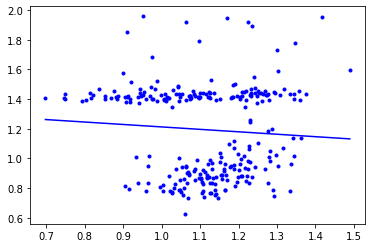

In [38]:
# calculate polynomial
z_dist = np.polyfit(avg_distREG, test_errREG, 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(avg_distREG), max(avg_distREG), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='blue')
plt.plot(avg_distREG, test_errREG, '.', color='blue')
plt.show()

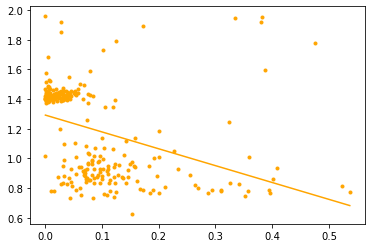

In [39]:
z_out = np.polyfit(avg_outREG, test_errREG, 1)
f_out = np.poly1d(z_out)

x_out = np.linspace(min(avg_outREG), max(avg_outREG), 100)
y_out = f_out(x_out)

plt.plot(x_out, y_out, color='orange')
plt.plot(avg_outREG, test_errREG, '.', color='orange')

In [40]:
# Define a function to deserialize the data
def deserialize(name, folder_name):
    with open(os.path.join(folder_name, name + ".pkl"), 'rb') as f:
        data = pickle.load(f, encoding='latin1', fix_imports=True)
    return data

In [41]:
################# CHOOSE SAMPLING METHOD #################
sampling_method = 'REG' # Either REG, UNI, or SOB for regular (grid), random (uniform), and Sobol

# Deserialize the data using pickle
folder_name = "serialized_hole/serialized_data_" + sampling_method + "_10_3_11"
list_names = ["list_dist_nv", "mean_dist", "mean_nv", "num_out", "output_test", "stdv_nv"]
list_data = []
for name in list_names:
    list_data.append(deserialize(name, folder_name))
    
list_dist_nv = list_data[0]
mean_dist = list_data[1]
mean_nv = list_data[2]
num_out = list_data[3]
output_test = list_data[4].detach().numpy()
stdv_nv = list_data[5]

In [42]:
train_size = 1024
test_size = 529
train_path = 'samples/train_data_f2_hole_' + str(train_size)
test_path = 'samples/test_data_f2_plain_' + str(test_size) + '/'

# Training and Testing samples
x_train, y_train = deserialize(sampling_method + "_x_train", train_path), deserialize(sampling_method + "_y_train", train_path)
x_test, y_test = deserialize("x_test", test_path), deserialize("y_test", test_path)

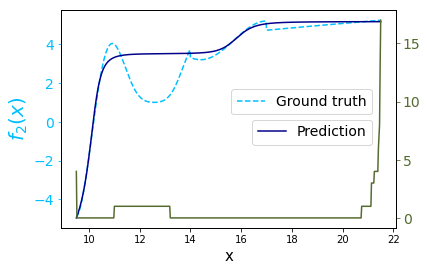

In [43]:
#Plot showing the number of nodes outside of range for a network
#and its prediction, compared to the ground truth

fig, ax1 = plt.subplots()

plt.rcParams["figure.figsize"] = (6,5)

p1, = ax1.plot(x_test, y_test, '--', color='deepskyblue')
ax1.set_ylabel(r'$f_2(x)$')
ax1.set_xlabel('x')
ax1.legend(['Ground truth'], bbox_to_anchor=(0.95, 0.67), fontsize=14)
ax1.yaxis.label.set_color(p1.get_color())
ax1.yaxis.label.set_fontsize(20)
ax1.xaxis.label.set_fontsize(15)
ax1.tick_params(axis='y', colors=p1.get_color(), labelsize=14)

ax2 = ax1.twiny()
p2, = ax2.plot(x_test, output_test, color='darkblue')
ax2.legend(['Prediction'], bbox_to_anchor=(0.95, 0.53), fontsize=14)
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

ax3 = ax1.twinx()
p3, = ax3.plot(x_test, num_out, color='darkolivegreen')
ax3.yaxis.label.set_color(p3.get_color())
ax3.yaxis.label.set_fontsize(20)
ax3.tick_params(axis='y', colors=p3.get_color(), labelsize=14)

plt.savefig("images/f2_10_3_out_holeREG.png", dpi=100)

In [44]:
#definition of a cost function
def mse(pred, truth):
    res = []
    for p, t in zip(pred, truth):
        res.append((p[0]-t[0])**2)
    return np.array(res)

In [45]:
################# CHOOSE SAMPLING METHOD #################
sampling_method = 'REG' # Either REG, UNI, or SOB for regular (grid), random (uniform), and Sobol

archs = [(6, 1), (7, 1), (12, 1), (17, 1), (22, 1), (27, 1), (32, 1),
    (6, 2), (8, 2), (10, 2), (12, 2), (14, 2), (16, 2),
    (6, 3), (8, 3), (10, 3)]
path = "serialized_hole/serialized_data_" + sampling_method

full_err = np.array([])
full_out = np.array([])
full_dist = np.array([])
full_xtest = np.array([])
X = x_test.detach().numpy().reshape(1, len(x_test))[0]

width = 10
depth = 3

for test_num in range(1, 18):
    # Deserialize the data using pickle
    folder_name = path + f"_{width}_{depth}_{test_num}"
    list_names = ["mean_dist", "num_out", "output_test"]
    list_data = []
    for name in list_names:
        list_data.append(deserialize(name, folder_name))

    mean_dist = list_data[0]
    num_out = list_data[1]
    output_test = list_data[2].detach().numpy()
    gen_err = mse(output_test, y_test)
    
    full_err = np.concatenate((full_err, gen_err))
    full_out = np.concatenate((full_out, num_out))
    full_dist = np.concatenate((full_dist, mean_dist))
    full_xtest = np.concatenate((full_xtest, X))

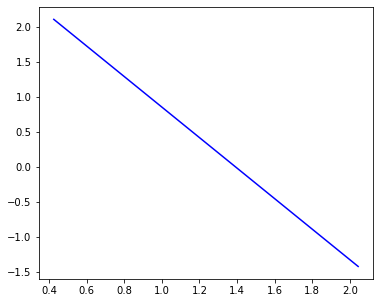

In [46]:
# calculate polynomial
z_dist = np.polyfit(full_dist, full_err, 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(full_dist), max(full_dist), 20)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='blue')
#plt.plot(full_dist, full_err, '.', color='blue')
plt.show()

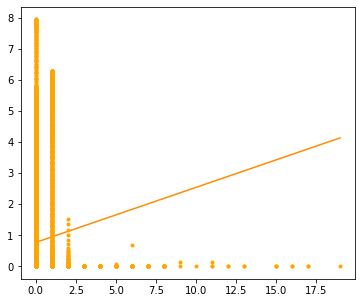

In [47]:
# calculate polynomial
z_dist = np.polyfit(full_out, full_err, 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(full_out), max(full_out), 20)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='darkorange')
plt.plot(full_out, full_err, '.', color='orange')
plt.show()

In [48]:
# Collect only node values outside of training range
stack = np.column_stack((full_out, full_dist, full_xtest, full_err))

# create a boolean mask based on your conditions
mask = np.logical_or((11 <= stack[:, 2]) & (stack[:, 2] <= 14), (17 <= stack[:, 2]) & (stack[:, 2] <= 20))

# use the mask to filter the stack array
filtered_stack = stack[mask]

/Users/timvalencony/pythonproject-test/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


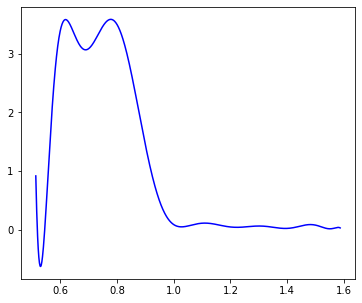

In [49]:
# calculate polynomial
z_dist = np.polyfit(filtered_stack[:, 1], filtered_stack[:, 3], 14)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(filtered_stack[:, 1]), max(filtered_stack[:, 1]), 1000)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='blue')
#plt.plot(filtered_stack[:, 1], filtered_stack[:, 3], '.', color='blue')
plt.show()

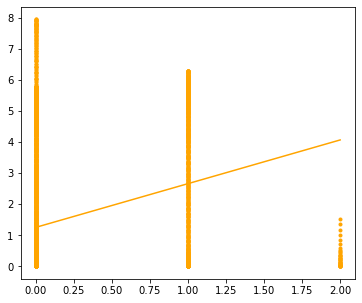

In [50]:
# calculate polynomial
z_dist = np.polyfit(filtered_stack[:, 0], filtered_stack[:, 3], 1)
f_dist = np.poly1d(z_dist)

# calculate new x's and y's
x_dist = np.linspace(min(filtered_stack[:, 0]), max(filtered_stack[:, 0]), 100)
y_dist = f_dist(x_dist)

plt.plot(x_dist, y_dist, color='orange')
plt.plot(filtered_stack[:, 0], filtered_stack[:, 3], '.', color='orange')
plt.show()

In [51]:
avg_out = sum(list(filtered_stack[:, 0])) / len(list(filtered_stack[:, 0]))
avg_dist = sum(list(filtered_stack[:, 1])) / len(list(filtered_stack[:, 1]))
avg_err = sum(list(filtered_stack[:, 3])) / len(list(filtered_stack[:, 3]))
print(avg_out, avg_dist, avg_err)

0.2089783281733746 0.9710127772605798 1.5499701120504867
